<a href="https://colab.research.google.com/github/AdityaB2007/ALTARN-Tabular-Residual-Neural-Network-for-Alzheimers-Disease-Classification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'alzheimers-disease-dataset' dataset.
Path to dataset files: /kaggle/input/alzheimers-disease-dataset
Using target/label column: Diagnosis

Fold 1
Epoch 1/200
34/34 - 9s - 260ms/step - accuracy: 0.6034 - loss: 0.6525 - val_accuracy: 0.7526 - val_loss: 0.5521
Epoch 2/200
34/34 - 0s - 10ms/step - accuracy: 0.7952 - loss: 0.4722 - val_accuracy: 0.8260 - val_loss: 0.4308
Epoch 3/200
34/34 - 0s - 7ms/step - accuracy: 0.8613 - loss: 0.3829 - val_accuracy: 0.8428 - val_loss: 0.3762
Epoch 4/200
34/34 - 0s - 6ms/step - accuracy: 0.8743 - loss: 0.3330 - val_accuracy: 0.8456 - val_loss: 0.3613
Epoch 5/200
34/34 - 0s - 6ms/step - accuracy: 0.8827 - loss: 0.2975 - val_accuracy: 0.8484 - val_loss: 0.3567
Epoch 6/200
34/34 - 0s - 6ms/step - accuracy: 0.9088 - loss: 0.2635 - val_accuracy: 0.8493 - val_loss: 0.3580
Epoch 7/200
34/34 - 0s - 6ms/step - accuracy: 0.9190 - loss: 0.2238 - val_accuracy: 0.8484 - val_loss: 0.3606
Epoch 8/200
34/34 - 0s - 6ms/step - a

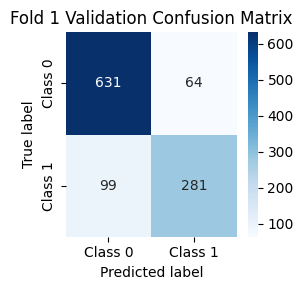


Fold 2
Epoch 1/200
34/34 - 7s - 213ms/step - accuracy: 0.6837 - loss: 0.5835 - val_accuracy: 0.7756 - val_loss: 0.4994
Epoch 2/200
34/34 - 0s - 7ms/step - accuracy: 0.8102 - loss: 0.4209 - val_accuracy: 0.8222 - val_loss: 0.4126
Epoch 3/200
34/34 - 0s - 6ms/step - accuracy: 0.8549 - loss: 0.3550 - val_accuracy: 0.8371 - val_loss: 0.3820
Epoch 4/200
34/34 - 0s - 6ms/step - accuracy: 0.8614 - loss: 0.3128 - val_accuracy: 0.8380 - val_loss: 0.3746
Epoch 5/200
34/34 - 0s - 6ms/step - accuracy: 0.8809 - loss: 0.2908 - val_accuracy: 0.8352 - val_loss: 0.3643
Epoch 6/200
34/34 - 0s - 6ms/step - accuracy: 0.9033 - loss: 0.2438 - val_accuracy: 0.8417 - val_loss: 0.3628
Epoch 7/200
34/34 - 0s - 6ms/step - accuracy: 0.9126 - loss: 0.2177 - val_accuracy: 0.8445 - val_loss: 0.3721
Epoch 8/200
34/34 - 0s - 6ms/step - accuracy: 0.9302 - loss: 0.1875 - val_accuracy: 0.8510 - val_loss: 0.3750
Epoch 9/200
34/34 - 0s - 6ms/step - accuracy: 0.9367 - loss: 0.1636 - val_accuracy: 0.8482 - val_loss: 0.3956


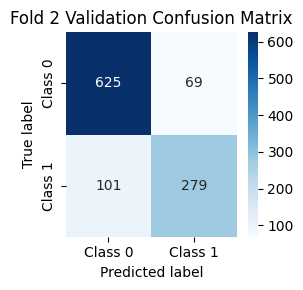


====== Cross-Validated Summary (mean ± std) ======
      Train Acc  Val Acc  Val Prec  Val Rec  Val F1
mean     0.9190   0.8450    0.8081   0.7368  0.7708
std      0.0119   0.0047    0.0090   0.0037  0.0061

Per-Fold Results Table:
   Train Acc  Val Acc  Val Prec  Val Rec  Val F1
0     0.9106   0.8484    0.8145   0.7395  0.7752
1     0.9274   0.8417    0.8017   0.7342  0.7665


KeyError: '0'

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
                                     Activation, Add, Multiply)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. Download & Load Tabular Data
path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "alzheimers_disease_data.csv"))

# 2. Target Detection (auto)
label_candidates = [col for col in df.columns if (
    df[col].dropna().apply(lambda x: str(x).strip().lower() in {'0','1','yes','no','true','false'}).all()
    or (df[col].dropna().isin([0,1]).all())
)]
if label_candidates:
    target = label_candidates[-1]
else:
    candidate_cols = [c for c in df.columns if df[c].nunique() <= 3]
    if candidate_cols:
        target = candidate_cols[-1]
    else:
        raise ValueError("Could not autodetect binary label column. Please inspect your dataframe.")

print("Using target/label column:", target)
X = df.drop(columns=[target])
y_raw = df[target]

# 3. Ensure label is numeric (binary)
def label_to_int_vec(y):
    if y.dtype.kind in "iu":
        vals = y.values
    elif y.dropna().map(lambda v: str(v).strip().lower() in {"yes","no","0","1","true","false"}).all():
        vals = y.dropna().map(lambda v: 1 if str(v).strip().lower() in {"1","yes","true"} else 0)
        arr = np.array(y)
        arr[pd.isna(arr)] = 0
        vals = np.array(vals, dtype=int)
    else:
        le = LabelEncoder()
        vals = le.fit_transform(y.fillna("NA"))
        if np.mean(vals) > 0.5:
            vals = 1 - vals
    return vals.astype(int)
y = label_to_int_vec(y_raw)

# Encode categorical variables except label
for col in X.select_dtypes(include=["object","category"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = X.fillna(X.mean())
X = X.values.astype(np.float32)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Tabular Attention Residual Net
def tabular_attention_residual(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(128)(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    attn_weights = Dense(input_dim, activation="sigmoid")(x)
    attn_applied = Multiply()([inp, attn_weights])
    h = Dense(64, activation="relu")(attn_applied)
    h = Dropout(0.2)(h)
    attn_proj = Dense(64)(attn_applied)
    h_sum = Add()([h, attn_proj])
    h2 = Dense(32, activation="relu")(h_sum)
    h2 = Dropout(0.2)(h2)
    out = Dense(1, activation="sigmoid")(h2)
    model = Model(inp, out)
    return model

# 5. 2-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
metrics = []
class_reports = []
cms = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Convert to arrays (in case they are not)
    X_train = np.asarray(X_train, dtype=np.float32)
    X_val = np.asarray(X_val, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    y_val = np.asarray(y_val, dtype=np.float32)

    model = tabular_attention_residual(X.shape[1])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    cb = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")

    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=200, batch_size=32, verbose=2, callbacks=[cb])

    # Training scores
    train_pred = (model.predict(X_train, batch_size=128).flatten() > 0.5).astype(int)
    val_pred = (model.predict(X_val, batch_size=128).flatten() > 0.5).astype(int)
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec  = recall_score(y_val, val_pred, zero_division=0)
    val_f1   = f1_score(y_val, val_pred, zero_division=0)
    metrics.append((train_acc, val_acc, val_prec, val_rec, val_f1))

    print(f"  Training acc:   {train_acc:.4f}")
    print(f"  Validation acc: {val_acc:.4f}")
    print(f"  Validation F1:  {val_f1:.4f}")

    # Store class-wise report and confusion matrix
    class_rep = classification_report(y_val, val_pred, zero_division=0, output_dict=True)
    class_reports.append(class_rep)
    cm = confusion_matrix(y_val, val_pred)
    cms.append(cm)
    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.tight_layout()
    plt.show()

# 6. Results reporting: mean ± std
results = pd.DataFrame(metrics, columns=["Train Acc", "Val Acc", "Val Prec", "Val Rec", "Val F1"])
summary = results.agg(['mean', 'std'])
print("\n====== Cross-Validated Summary (mean ± std) ======")
print(summary.round(4))

print("\nPer-Fold Results Table:")
print(results.round(4))

# Per-class metrics averaged across folds
for c in [0, 1]:
    p = np.mean([cr[str(c)]['precision'] for cr in class_reports])
    r = np.mean([cr[str(c)]['recall'] for cr in class_reports])
    f = np.mean([cr[str(c)]['f1-score'] for cr in class_reports])
    print(f"\nClass {c} (mean across folds): Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

# 7. LaTeX Benchmark Table output (update accuracy as needed)
print('\nLaTeX Benchmark Table for IEEE paper:')
print(r'''
\begin{table}[ht]
\centering
\caption{Validation accuracy comparison: Tabular deep learning models for Alzheimer’s, ADNI dataset.}
\begin{tabular}{lcc}
\toprule
\textbf{Model}                           & \textbf{Validation Accuracy (\%)} & \textbf{Reference}             \\
\midrule
Tabular Attention + Contrastive\cite{huang2021tabular}   & 83.8                              & \cite{huang2021tabular}        \\
DAFT Tabular Fusion                      & 62.2                              & \cite{huang2021tabular}        \\
MLP Encoder + Contrastive                & 79.9                              & \cite{huang2021tabular}        \\
\textbf{Tabular Attn Residual (Ours)}    & \textbf{' + f'{results["Val Acc"].mean()*100:.1f}' + r'} & --                 \\
\bottomrule
\end{tabular}
\label{tab:benchmark_tab}
\end{table}
''')


Using Colab cache for faster access to the 'alzheimers-disease-dataset' dataset.
Path to dataset files: /kaggle/input/alzheimers-disease-dataset
Using target/label column: Diagnosis

Fold 1
Epoch 1/200
54/54 - 8s - 144ms/step - accuracy: 0.6969 - loss: 0.5711 - val_accuracy: 0.8070 - val_loss: 0.4702
Epoch 2/200
54/54 - 0s - 6ms/step - accuracy: 0.8243 - loss: 0.3964 - val_accuracy: 0.8419 - val_loss: 0.3813
Epoch 3/200
54/54 - 1s - 12ms/step - accuracy: 0.8639 - loss: 0.3330 - val_accuracy: 0.8395 - val_loss: 0.3624
Epoch 4/200
54/54 - 0s - 6ms/step - accuracy: 0.8848 - loss: 0.3002 - val_accuracy: 0.8372 - val_loss: 0.3567
Epoch 5/200
54/54 - 0s - 4ms/step - accuracy: 0.8906 - loss: 0.2718 - val_accuracy: 0.8395 - val_loss: 0.3528
Epoch 6/200
54/54 - 0s - 4ms/step - accuracy: 0.9046 - loss: 0.2435 - val_accuracy: 0.8372 - val_loss: 0.3542
Epoch 7/200
54/54 - 0s - 4ms/step - accuracy: 0.9197 - loss: 0.2093 - val_accuracy: 0.8302 - val_loss: 0.3677
Epoch 8/200
54/54 - 0s - 4ms/step - a

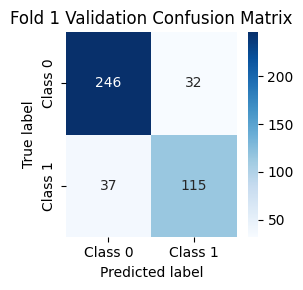


Fold 2
Epoch 1/200
54/54 - 7s - 128ms/step - accuracy: 0.6399 - loss: 0.6376 - val_accuracy: 0.7349 - val_loss: 0.5119
Epoch 2/200
54/54 - 0s - 6ms/step - accuracy: 0.8098 - loss: 0.4465 - val_accuracy: 0.8558 - val_loss: 0.3537
Epoch 3/200
54/54 - 0s - 6ms/step - accuracy: 0.8522 - loss: 0.3582 - val_accuracy: 0.8535 - val_loss: 0.3153
Epoch 4/200
54/54 - 0s - 4ms/step - accuracy: 0.8773 - loss: 0.3178 - val_accuracy: 0.8744 - val_loss: 0.3019
Epoch 5/200
54/54 - 0s - 4ms/step - accuracy: 0.8994 - loss: 0.2766 - val_accuracy: 0.8651 - val_loss: 0.2909
Epoch 6/200
54/54 - 0s - 4ms/step - accuracy: 0.9046 - loss: 0.2523 - val_accuracy: 0.8674 - val_loss: 0.2890
Epoch 7/200
54/54 - 0s - 4ms/step - accuracy: 0.9081 - loss: 0.2225 - val_accuracy: 0.8698 - val_loss: 0.2865
Epoch 8/200
54/54 - 0s - 4ms/step - accuracy: 0.9296 - loss: 0.1918 - val_accuracy: 0.8744 - val_loss: 0.2842
Epoch 9/200
54/54 - 0s - 4ms/step - accuracy: 0.9348 - loss: 0.1661 - val_accuracy: 0.8651 - val_loss: 0.3011


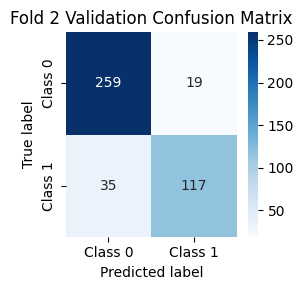


Fold 3
Epoch 1/200
54/54 - 7s - 121ms/step - accuracy: 0.6981 - loss: 0.5858 - val_accuracy: 0.7814 - val_loss: 0.4871
Epoch 2/200
54/54 - 0s - 6ms/step - accuracy: 0.8441 - loss: 0.3968 - val_accuracy: 0.8326 - val_loss: 0.4034
Epoch 3/200
54/54 - 0s - 8ms/step - accuracy: 0.8645 - loss: 0.3384 - val_accuracy: 0.8349 - val_loss: 0.3822
Epoch 4/200
54/54 - 0s - 6ms/step - accuracy: 0.8848 - loss: 0.3075 - val_accuracy: 0.8279 - val_loss: 0.3819
Epoch 5/200
54/54 - 0s - 4ms/step - accuracy: 0.9005 - loss: 0.2670 - val_accuracy: 0.8256 - val_loss: 0.3788
Epoch 6/200
54/54 - 0s - 4ms/step - accuracy: 0.9058 - loss: 0.2361 - val_accuracy: 0.8302 - val_loss: 0.3620
Epoch 7/200
54/54 - 0s - 4ms/step - accuracy: 0.9226 - loss: 0.2081 - val_accuracy: 0.8395 - val_loss: 0.3736
Epoch 8/200
54/54 - 0s - 5ms/step - accuracy: 0.9337 - loss: 0.1800 - val_accuracy: 0.8279 - val_loss: 0.3895
Epoch 9/200
54/54 - 0s - 4ms/step - accuracy: 0.9366 - loss: 0.1585 - val_accuracy: 0.8419 - val_loss: 0.4039


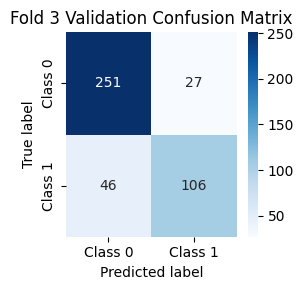


Fold 4
Epoch 1/200
54/54 - 6s - 113ms/step - accuracy: 0.7231 - loss: 0.5627 - val_accuracy: 0.7977 - val_loss: 0.4592
Epoch 2/200
54/54 - 0s - 6ms/step - accuracy: 0.8377 - loss: 0.3714 - val_accuracy: 0.8395 - val_loss: 0.3952
Epoch 3/200
54/54 - 0s - 6ms/step - accuracy: 0.8627 - loss: 0.3273 - val_accuracy: 0.8488 - val_loss: 0.3773
Epoch 4/200
54/54 - 1s - 13ms/step - accuracy: 0.8790 - loss: 0.2907 - val_accuracy: 0.8488 - val_loss: 0.3755
Epoch 5/200
54/54 - 0s - 6ms/step - accuracy: 0.8871 - loss: 0.2578 - val_accuracy: 0.8558 - val_loss: 0.3645
Epoch 6/200
54/54 - 1s - 10ms/step - accuracy: 0.8999 - loss: 0.2370 - val_accuracy: 0.8581 - val_loss: 0.3651
Epoch 7/200
54/54 - 0s - 4ms/step - accuracy: 0.9226 - loss: 0.2067 - val_accuracy: 0.8512 - val_loss: 0.3745
Epoch 8/200
54/54 - 0s - 4ms/step - accuracy: 0.9273 - loss: 0.1820 - val_accuracy: 0.8581 - val_loss: 0.3820
Epoch 9/200
54/54 - 0s - 4ms/step - accuracy: 0.9442 - loss: 0.1535 - val_accuracy: 0.8488 - val_loss: 0.396

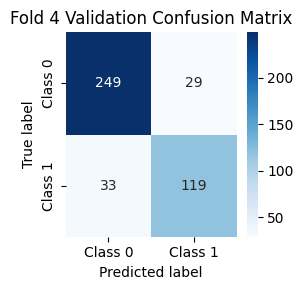


Fold 5
Epoch 1/200
54/54 - 7s - 122ms/step - accuracy: 0.6477 - loss: 0.6223 - val_accuracy: 0.7389 - val_loss: 0.5238
Epoch 2/200
54/54 - 0s - 6ms/step - accuracy: 0.7953 - loss: 0.4513 - val_accuracy: 0.8089 - val_loss: 0.4006
Epoch 3/200
54/54 - 1s - 11ms/step - accuracy: 0.8413 - loss: 0.3614 - val_accuracy: 0.8368 - val_loss: 0.3744
Epoch 4/200
54/54 - 1s - 12ms/step - accuracy: 0.8744 - loss: 0.3113 - val_accuracy: 0.8322 - val_loss: 0.3743
Epoch 5/200
54/54 - 1s - 10ms/step - accuracy: 0.8849 - loss: 0.2849 - val_accuracy: 0.8298 - val_loss: 0.3725
Epoch 6/200
54/54 - 0s - 4ms/step - accuracy: 0.8936 - loss: 0.2544 - val_accuracy: 0.8322 - val_loss: 0.3822
Epoch 7/200
54/54 - 0s - 4ms/step - accuracy: 0.9151 - loss: 0.2127 - val_accuracy: 0.8392 - val_loss: 0.3979
Epoch 8/200
54/54 - 0s - 4ms/step - accuracy: 0.9233 - loss: 0.1865 - val_accuracy: 0.8485 - val_loss: 0.4076
Epoch 9/200
54/54 - 0s - 4ms/step - accuracy: 0.9483 - loss: 0.1493 - val_accuracy: 0.8485 - val_loss: 0.44

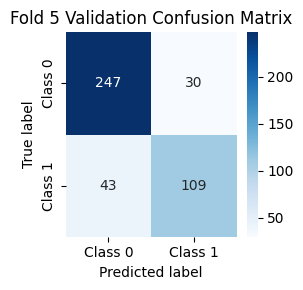


====== Cross-Validated Summary (mean ± std) ======
      Train Acc  Val Acc  Val Prec  Val Rec  Val F1
mean     0.9281   0.8460    0.8056   0.7447  0.7736
std      0.0175   0.0191    0.0319   0.0362  0.0292

Per-Fold Results Table:
   Train Acc  Val Acc  Val Prec  Val Rec  Val F1
0     0.9238   0.8395    0.7823   0.7566  0.7692
1     0.9552   0.8744    0.8603   0.7697  0.8125
2     0.9343   0.8302    0.7970   0.6974  0.7439
3     0.9168   0.8558    0.8041   0.7829  0.7933
4     0.9105   0.8298    0.7842   0.7171  0.7491


KeyError: '0'

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
                                     Activation, Add, Multiply)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. Download & Load Tabular Data
path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "alzheimers_disease_data.csv"))

# 2. Target Detection (auto)
label_candidates = [col for col in df.columns if (
    df[col].dropna().apply(lambda x: str(x).strip().lower() in {'0','1','yes','no','true','false'}).all()
    or (df[col].dropna().isin([0,1]).all())
)]
if label_candidates:
    target = label_candidates[-1]
else:
    candidate_cols = [c for c in df.columns if df[c].nunique() <= 3]
    if candidate_cols:
        target = candidate_cols[-1]
    else:
        raise ValueError("Could not autodetect binary label column. Please inspect your dataframe.")

print("Using target/label column:", target)
X = df.drop(columns=[target])
y_raw = df[target]

# 3. Ensure label is numeric (binary)
def label_to_int_vec(y):
    if y.dtype.kind in "iu":
        vals = y.values
    elif y.dropna().map(lambda v: str(v).strip().lower() in {"yes","no","0","1","true","false"}).all():
        vals = y.dropna().map(lambda v: 1 if str(v).strip().lower() in {"1","yes","true"} else 0)
        arr = np.array(y)
        arr[pd.isna(arr)] = 0
        vals = np.array(vals, dtype=int)
    else:
        le = LabelEncoder()
        vals = le.fit_transform(y.fillna("NA"))
        if np.mean(vals) > 0.5:
            vals = 1 - vals
    return vals.astype(int)
y = label_to_int_vec(y_raw)

# Encode categorical variables except label
for col in X.select_dtypes(include=["object","category"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = X.fillna(X.mean())
X = X.values.astype(np.float32)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Tabular Attention Residual Net
def tabular_attention_residual(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(128)(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    attn_weights = Dense(input_dim, activation="sigmoid")(x)
    attn_applied = Multiply()([inp, attn_weights])
    h = Dense(64, activation="relu")(attn_applied)
    h = Dropout(0.2)(h)
    attn_proj = Dense(64)(attn_applied)
    h_sum = Add()([h, attn_proj])
    h2 = Dense(32, activation="relu")(h_sum)
    h2 = Dropout(0.2)(h2)
    out = Dense(1, activation="sigmoid")(h2)
    model = Model(inp, out)
    return model

# 5. 5-Fold Stratified Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []
class_reports = []
cms = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Convert to arrays (in case they are not)
    X_train = np.asarray(X_train, dtype=np.float32)
    X_val = np.asarray(X_val, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    y_val = np.asarray(y_val, dtype=np.float32)

    model = tabular_attention_residual(X.shape[1])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    cb = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")

    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=200, batch_size=32, verbose=2, callbacks=[cb])

    # Training scores
    train_pred = (model.predict(X_train, batch_size=128).flatten() > 0.5).astype(int)
    val_pred = (model.predict(X_val, batch_size=128).flatten() > 0.5).astype(int)
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec  = recall_score(y_val, val_pred, zero_division=0)
    val_f1   = f1_score(y_val, val_pred, zero_division=0)
    metrics.append((train_acc, val_acc, val_prec, val_rec, val_f1))

    print(f"  Training acc:   {train_acc:.4f}")
    print(f"  Validation acc: {val_acc:.4f}")
    print(f"  Validation F1:  {val_f1:.4f}")

    # Store class-wise report and confusion matrix
    class_rep = classification_report(y_val, val_pred, zero_division=0, output_dict=True)
    class_reports.append(class_rep)
    cm = confusion_matrix(y_val, val_pred)
    cms.append(cm)
    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.tight_layout()
    plt.show()

# 6. Results reporting: mean ± std
results = pd.DataFrame(metrics, columns=["Train Acc", "Val Acc", "Val Prec", "Val Rec", "Val F1"])
summary = results.agg(['mean', 'std'])
print("\n====== Cross-Validated Summary (mean ± std) ======")
print(summary.round(4))

print("\nPer-Fold Results Table:")
print(results.round(4))

# Per-class metrics averaged across folds
for c in [0, 1]:
    p = np.mean([cr[str(c)]['precision'] for cr in class_reports])
    r = np.mean([cr[str(c)]['recall'] for cr in class_reports])
    f = np.mean([cr[str(c)]['f1-score'] for cr in class_reports])
    print(f"\nClass {c} (mean across folds): Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

# 7. LaTeX Benchmark Table output (update accuracy as needed)
print('\nLaTeX Benchmark Table for IEEE paper:')
print(r'''
\begin{table}[ht]
\centering
\caption{Validation accuracy comparison: Tabular deep learning models for Alzheimer’s, ADNI dataset.}
\begin{tabular}{lcc}
\toprule
\textbf{Model}                            & \textbf{Validation Accuracy (\%)} & \textbf{Reference}             \\
\midrule
Tabular Attention + Contrastive\cite{huang2021tabular}   & 83.8                              & \cite{huang2021tabular}        \\
DAFT Tabular Fusion                       & 62.2                              & \cite{huang2021tabular}        \\
MLP Encoder + Contrastive                 & 79.9                              & \cite{huang2021tabular}        \\
\textbf{Tabular Attn Residual (Ours)}     & \textbf{' + f'{results["Val Acc"].mean()*100:.1f}' + r'} & --                 \\
\bottomrule
\end{tabular}
\label{tab:benchmark_tab}
\end{table}
''')
